In [1]:
from __future__ import print_function, division
from builtins import range

import numpy as np


class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    assert(self.current_state() in self.all_states())

  def game_over(self):
    return (self.i, self.j) not in self.actions

  def all_states(self):
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost = -0.1):
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g

In [2]:
import numpy as np

SMALL_ENOUGH = 1e-3 # threshold for convergence
GAMMA = 0.9
ALPHA = 0.1

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") 
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")
    
def random_action(a, eps=0.1):
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val 

it: 0
it: 2000
it: 4000
it: 6000
it: 8000


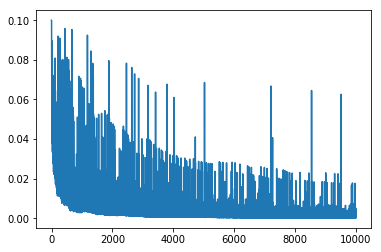

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.18| 0.00| 0.04| 0.00|
---------------------------
 0.19| 0.02| 0.03| 0.00|
values:
---------------------------
 0.49| 0.72| 1.00| 0.00|
---------------------------
 0.29| 0.00| 0.70| 0.00|
---------------------------
 0.12| 0.14| 0.35| 0.11|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [7]:
import matplotlib.pyplot as plt

GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


if __name__ == '__main__':
    grid = negative_grid(step_cost=-0.1)
    
    # initialize Q(s,a)
    Q = {}
    states = grid.all_states()
    for s in states:
        Q[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0
            
    #track number of updates
    update_counts = {}
    update_counts_sa = {}
    for s in states:
        update_counts_sa[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            update_counts_sa[s][a] = 1.0
    
    #Repeat until convergence
    t = 1.0
    deltas = []
    for it in range(10000):
        if it % 100 == 0:
            t += 1e-2
        if it % 2000 == 0:
            print("it:", it)
        
        s = (2,0)
        grid.set_state(s)
        
        a = max_dict(Q[s])[0]
        a = random_action(a, eps=0.5/t)
        biggest_change = 0
        while not grid.game_over():
            r = grid.move(a)
            s2 = grid.current_state()
            
            a2 = max_dict(Q[s2])[0]
            a2 = random_action(a2, eps=0.5/t)
            
            alpha = ALPHA / update_counts_sa[s][a]
            update_counts_sa[s][a] += 0.005
            
            old_qsa = Q[s][a]
            Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
            biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))      
            
            update_counts[s] = update_counts.get(s,0) + 1

            s = s2
            a = a2
        deltas.append(biggest_change)
        
          
    plt.plot(deltas)
  
    plt.show()

  # determine the policy from Q*
  # find V* from Q*
    policy = {}
    V = {}
    for s in grid.actions.keys():
        a, max_q = max_dict(Q[s])
        policy[s] = a
        V[s] = max_q

    print("update counts:")
    total = np.sum(list(update_counts.values()))
    
    for k, v in update_counts.items():
        update_counts[k] = float(v) / total
  
    print_values(update_counts, grid)

    print("values:")
    print_values(V, grid)
    print("policy:")
    print_policy(policy, grid)